**@juliaroquette** in this test we focus on data from Gaia DR3. 

This is a list of stars from the DR3 GaiaVari YSO sample:

| DR3 source_id |
|-----------------|
|5884016208181951232|
|5530588125315419136|
|6262576790231189248|
|6049313453321383168|
|6073363238660815104|
|2064455028158369024|
|2162657011547210752|
|5997410491550194816|
|529005594229997696|

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from astroquery.vizier import Vizier
import pandas as pd
import sys
sys.path.append('../')  
from variability.lightcurve import LightCurve, FoldedLightCurve
from variability.indexes import VariabilityIndex
from variability.timescales import TimeScale

/Users/juliaroquette/anaconda3/envs/NEMESIS/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Data Access:

**@juliaroquette**: Here I will be using `astroquery.Vizier` for retrieving the data. For the real implementation, I suppose Màté can talk to Greg to see how he can do the same within the Gaia system. 
For the moment, I am also exporting these light-curves as `.csv` files into `jupyter/data/`.

In [2]:
ref_stars = [5884016208181951232, 5530588125315419136, 
             6262576790231189248, 6049313453321383168, 
             6073363238660815104, 2064455028158369024, 
             2162657011547210752, 5997410491550194816, 
             529005594229997696]

Initialize `astroquery.Vizier`:

In [3]:
gdr3_epphot = Vizier(catalog='I/355/epphot', row_limit=-1)

Query Vizier for a given `source_id`

In [4]:
print('... source_id ...')
print('number of light-curves found - number of epochs - number of columns in the results table')
light_curves = []
for source_id in ref_stars:
    print(source_id)
    result = gdr3_epphot.query_constraints(Source=source_id)
    print(len(result), len(result[0]), len(result[0][0]))
    light_curves.append(result[0])

... source_id ...
number of light-curves found - number of epochs - number of columns in the results table
5884016208181951232
1 66 48
5530588125315419136
1 49 48
6262576790231189248
1 45 48
6049313453321383168
1 51 48
6073363238660815104
1 109 48
2064455028158369024
1 55 48
2162657011547210752
1 50 48
5997410491550194816
1 72 48
529005594229997696
1 49 48


Note, however, that `astroquery.Vizier` comes with a small bug here, in that they do not properly give you the names of the columns, so I had to retrieve this manually by going directly to the `I/358` table on CDS (https://vizier.cds.unistra.fr/viz-bin/VizieR-3?-source=I/358&-out.max=50&-out.form=HTML%20Table&-out.add=_r&-out.add=_RAJ,_DEJ&-sort=_r&-oc.form=sexa), downloading the table in some format that includes meta-data and then manually introducing their correct names:

In [5]:
correct_names = ['source_id', 'RA_ICRS', 'DE_ICRS', 'TransitID', 'TimeG', 'FG', 'e_FG', 'RFG', 'Gmag', 'NG', 'TimeBP', 'FBP', 'e_FBP', 'RFBP', 'BPmag', 'TimeRP', 'FRP', 'e_FRP', 'RFRP', 'RPmag', 'noisyFlag', 'SMuFlag', 'AF1uFlag', 'AF2uFlag', 'AF3uFlag', 'AF4uFlag', 'AF5uFlag', 'AF6uFlag', 'AF7uFlag', 'AF8uFlag', 'AF9uFlag', 'BPuFlag', 'RPuFlag', 'SMrFlag', 'AF1rFlag', 'AF2rFlag', 'AF3rFlag', 'AF4rFlag', 'AF5rFlag', 'AF6rFlag', 'AF7rFlag', 'AF8rFlag', 'AF9rFlag', 'BPrFlag', 'RPrFlag', 'GrVFlag', 'BPrVFlag', 'RPrVFlag']
len(correct_names)

48

In [6]:
for i in range(len(light_curves)):
    for old, new in zip(light_curves[i][1].colnames , correct_names):
        light_curves[i].rename_column(old, new)

Next, if we are working in magnitudes, we need to convert flux uncertainties into magnitude uncertainties:

In [7]:
 for i in range(len(light_curves)):
    for ft in ['G', 'BP', 'RP']:
        light_curves[i]['e_' + ft + 'mag'] = 2.5 * light_curves[i]['e_F' + ft]/ light_curves[i]['F' + ft]/np.log(10)

Finally, following Marc's recommendation, we need to clean up the data rVFlag

In [8]:
for i in range(len(light_curves)):
  for ft in ['G', 'BP', 'RP']:
    to_clean = np.where(light_curves[i][ft + 'rVFlag'] != 0)[0]
    light_curves[i][ft + 'mag'][to_clean] = np.nan
    for field in ['Time', 'F', 'e_F', 'RF']:
      light_curves[i][field + ft][to_clean] = np.nan

In [9]:
for i in range(len(light_curves)):
     for field in ['TransitID', 'noisyFlag', 'SMuFlag', 'AF1uFlag', 'AF2uFlag', 'AF3uFlag',
              'AF4uFlag', 'AF5uFlag', 'AF6uFlag', 'AF7uFlag', 'AF8uFlag', 'AF9uFlag',
              'BPuFlag', 'RPuFlag', 'SMrFlag', 'AF1rFlag', 'AF2rFlag', 'AF3rFlag', 
              'AF4rFlag', 'AF5rFlag', 'AF6rFlag', 'AF7rFlag', 'AF8rFlag', 'AF9rFlag',
              'BPrFlag', 'RPrFlag', 'GrVFlag', 'BPrVFlag', 'RPrVFlag']:
        del light_curves[i][field]

Export these light-curves so Màté can use them. 

In [10]:
for i, source_id in enumerate(ref_stars):
    light_curves[i].to_pandas().to_csv('data/light_curve_GaiaDR3_' + str(source_id) + '.csv', index=False)

**Some Basic visualization:**

In [11]:
light_curves_ = []
for i in range(len(light_curves)):
    time = light_curves[i]['TimeG']
    mag = light_curves[i]['Gmag']
    err = light_curves[i]['e_Gmag']
    light_curves_.append(LightCurve(time, mag, err))

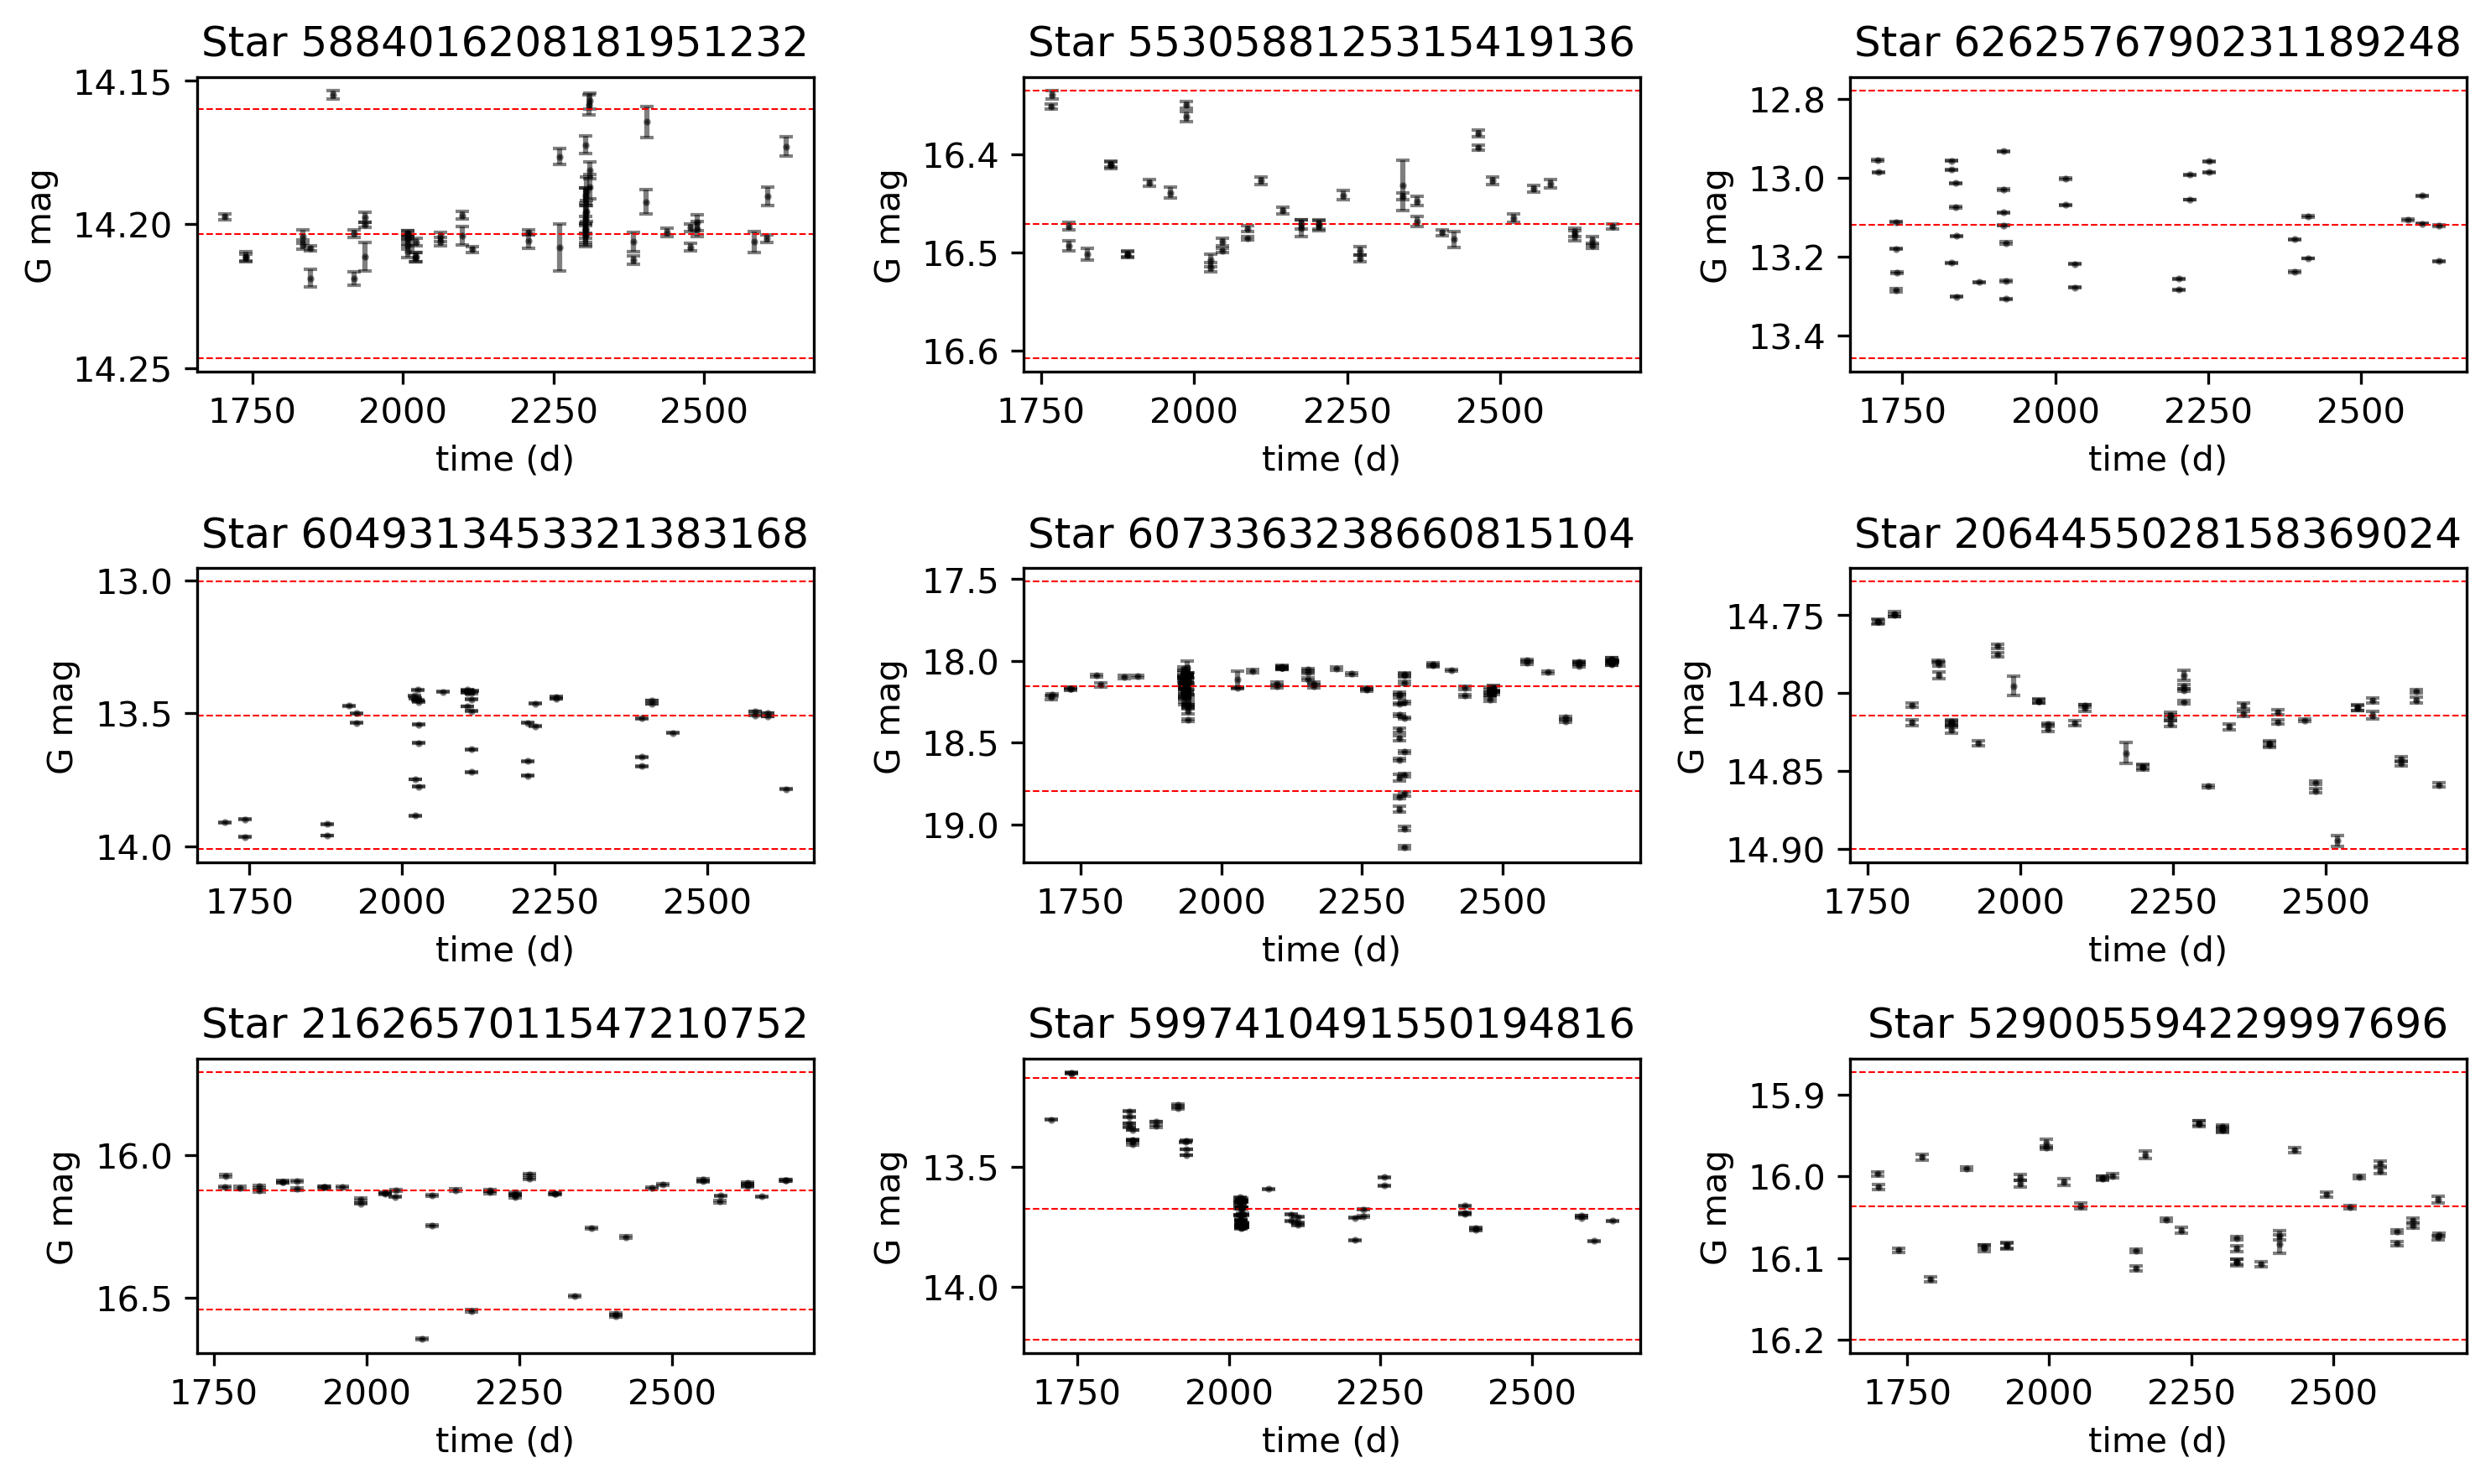

In [12]:
fig, ax = plt.subplots(3, 3, figsize = (10, 6), dpi=300)
ax = ax.flatten()
for i, source_id in enumerate(ref_stars):
    lc = light_curves_[i]
    ax[i].errorbar(lc.time, lc.mag, lc.err, fmt='.', capsize=2, color='k', ms=2, alpha=0.5)
    ax[i].set_title('Star ' + str(source_id))
    ax[i].set_xlabel('time (d)')
    ax[i].set_ylabel('G mag')
    ax[i].invert_yaxis()
    ax[i].axhline(np.nanmedian(lc.mag), ls='--', color='r', lw=0.5)
    ax[i].axhline(np.nanmedian(lc.mag) + 3*np.nanstd(lc.mag), ls='--', color='r', lw=0.5)
    ax[i].axhline(np.nanmedian(lc.mag) - 3*np.nanstd(lc.mag), ls='--', color='r', lw=0.5)

plt.tight_layout()
plt.savefig('/Users/juliaroquette/Work/Plots/GaiaDR3_testing_stars_Lcs.png', dpi=300, bbox_inches='tight')

# Timescale

For the moment, the timescale is being obtained with the Lomb-Scargle Periodogram. 

An implementation for the Lomb-Scargle periodogram should already exist in VariPipe (`VariPeriodSearch`)

- Periodogram on Gaia VariPipe:
    -  https://gaia.esac.esa.int/dpacsvn/DPAC/CU7/docs/characterisation/period_search/sdd/GAIA-C7-SP-ROB-AJ-001.pdf
    - https://gaia.esac.esa.int/dpacsvn/DPAC/CU7/docs/characterisation/period_search/srs/GAIA-C7-SP-ROB-JCU-002.pdf
    - https://gaia.esac.esa.int/dpacsvn/DPAC/CU7/docs/characterisation/period_search/code_review/Cycle17/ 
    - [FAP - False Alarm Probability - Section 2.1] https://gaia.esac.esa.int/dpacsvn/DPAC/CU7/docs/characterisation/technotes/GAIA-C7-TN-ROB-JCU-008/GAIA-C7-TN-ROB-JCU-008.pdf 
    - [Lomb-Scargle - Section 4] https://gaia.esac.esa.int/dpacsvn/DPAC/CU7/docs/characterisation/technotes/GAIA-C7-TN-ROB-JCU-011/GAIA-C7-TN-ROB-JCU-011.pdf
    - https://gaia.esac.esa.int/dpacsvn/DPAC/CU7/docs/vari_system/srn/periodsearch/R_20.0/GAIA-C7-SP-GEN-LPG-081.pdf 
    - https://gaia.esac.esa.int/dpacsvn/DPAC/CU7/docs/vari_system/srn/periodsearch/R_20.1/GAIA-C7-SP-GEN-MAU-003.pdf 
    - https://gaia.esac.esa.int/dpacsvn/DPAC/CU7/docs/vari_system/srn/periodsearch/R_21.0/GAIA-C7-SP-GEN-MAU-014.pdf
    - https://gaia.esac.esa.int/dpacsvn/DPAC/CU7/docs/vari_system/srn/periodsearch/R_21.3/GAIA-C7-SP-GEN-MAU-028.pdf

Future: This will include the use of Variograms for getting timescales for the low-FAP peaks (when `FAP_highest_peak > 0.01`). An implementation of Variograms exists as part of the `shorttimescale` package in `VariPipe` and we will try to adapt it. (https://gaia.esac.esa.int/dpacsvn/DPAC/CU7/software/VariSpecialDetection/SVD_ShortTimeScale/src/gaia/cu7/algo/specialdetection/shorttimescale/)

**@juliaroquette** it would be really useful if @Mate could translate this Variogram implementation into Python so we can validate it againts Clhoé's version. 

In [13]:
timescales = []
periodogram = []
for i in range(len(light_curves)):
    lc = light_curves_[i]
    timescale = TimeScale(lc)
    frequency, power, FAP = timescale.get_LSP_period(periodogram=True)
    periodogram.append(timescale.get_LSP_period(periodogram=True))
    timescales.append(timescale.get_LSP_period(periodogram=False))

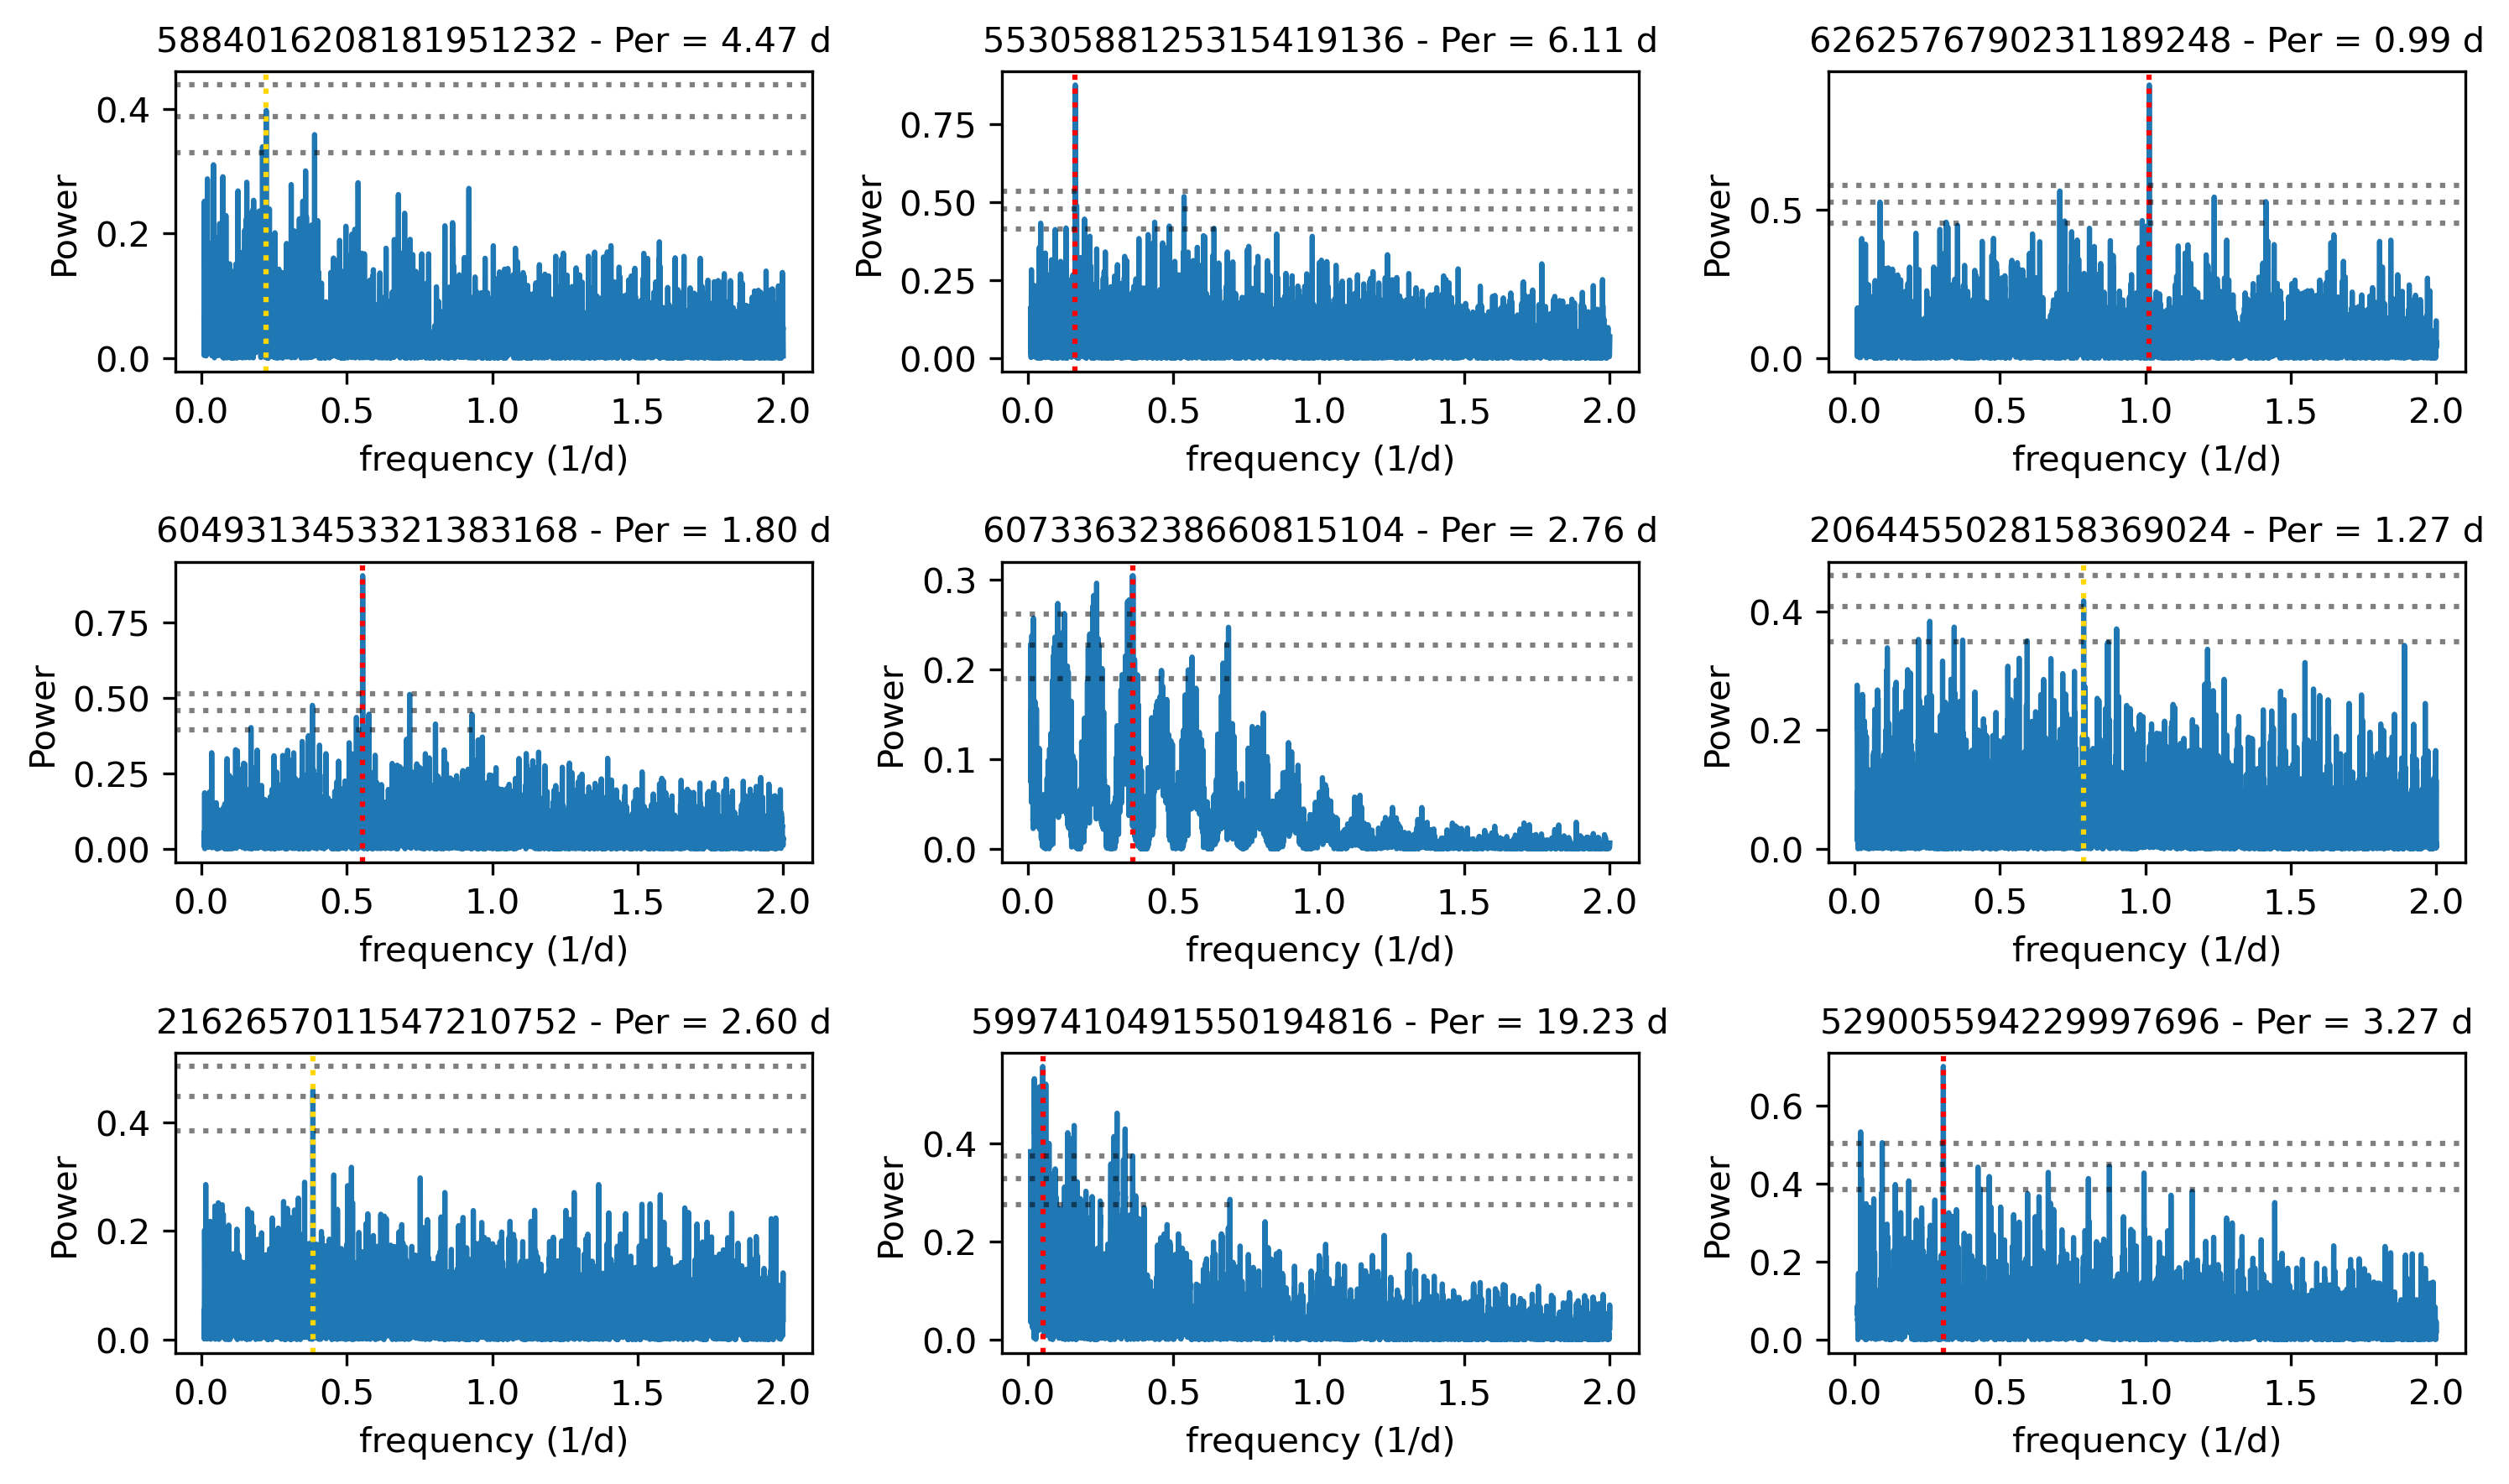

In [14]:
fig, ax = plt.subplots(3, 3, figsize = (10, 6), dpi=300)
ax = ax.flatten()
for i, source_id in enumerate(ref_stars):
    frequency, power, FAP = periodogram[i]
    best_frequency, power_highest_peak, FAP_highest_peak = timescales[i]
    ax[i].plot(frequency, power)
    if FAP_highest_peak <= 0.001:
        c = 'r'
    elif FAP_highest_peak < 0.01:
        c = 'gold'
    else:
        c = 'g'
    ax[i].axvline(best_frequency, color=c, linestyle=':')
    for p in FAP:
        ax[i].axhline(p, color='k', linestyle=':', alpha=0.5)
    
     

    ax[i].set_title('{0} - Per = {1:.2f} d'.format(source_id, 1./best_frequency), fontsize=10)
    ax[i].set_xlabel('frequency (1/d)')
    ax[i].set_ylabel('Power')
    # ax[i].invert_yaxis()

plt.tight_layout()
# plt.savefig('/Users/juliaroquette/Work/Plots/GaiaDR3_testing_stars_LSPs.png', dpi=300, bbox_inches='tight')

In [15]:
def fap_level(fap):
    if fap <= 0.001:
        return 1
    elif fap < 0.01:
        return 0
    else:
        return -1

In [16]:
print('source_id \t period \t type')
for i, source_id in enumerate(ref_stars):
    best_frequency, power_highest_peak, fap = timescales[i]
    print(source_id, 1./best_frequency, fap_level(fap))

source_id 	 period 	 type
5884016208181951232 4.467543472552248 0
5530588125315419136 6.109209225411241 1
6262576790231189248 0.9865213704237824 1
6049313453321383168 1.8015366624877287 1
6073363238660815104 2.7619412762568554 1
2064455028158369024 1.2685936392124528 0
2162657011547210752 2.602696988407531 0
5997410491550194816 19.23138798575119 1
529005594229997696 3.265170763051135 1


Before entering into the task of incorporating the VariPipe LombScargle version, we can use the periods below as a testing time-scale:

`type`:
- `1`: Reliable timescale 
- `0`: possibly unreliable timescale 
- `-1`: spurious timescale 

| source_id | period | type |
|-----------------|-----------------|-----------------|
|5884016208181951232 |4.467543472552248 |0|
|5530588125315419136 |6.109209225411241 |1|
|6262576790231189248 |0.9865213704237824 |1|
|6049313453321383168 |1.8015366624877287 |1|
|6073363238660815104 |2.7619412762568554 |1|
|2064455028158369024 |1.2685936392124528 |0|
|2162657011547210752 |2.602696988407531 |0|
|5997410491550194816 |19.23138798575119 |1|
|529005594229997696 |3.265170763051135 |1|

These timescales can be used to phase-fold the light-curves:

In [17]:
folded_light_curves = []
for i, source_id in enumerate(ref_stars):
     best_frequency, power_highest_peak, per_type = timescales[i]
     folded_light_curves.append(FoldedLightCurve(lc=light_curves_[i], timescale=1./best_frequency))

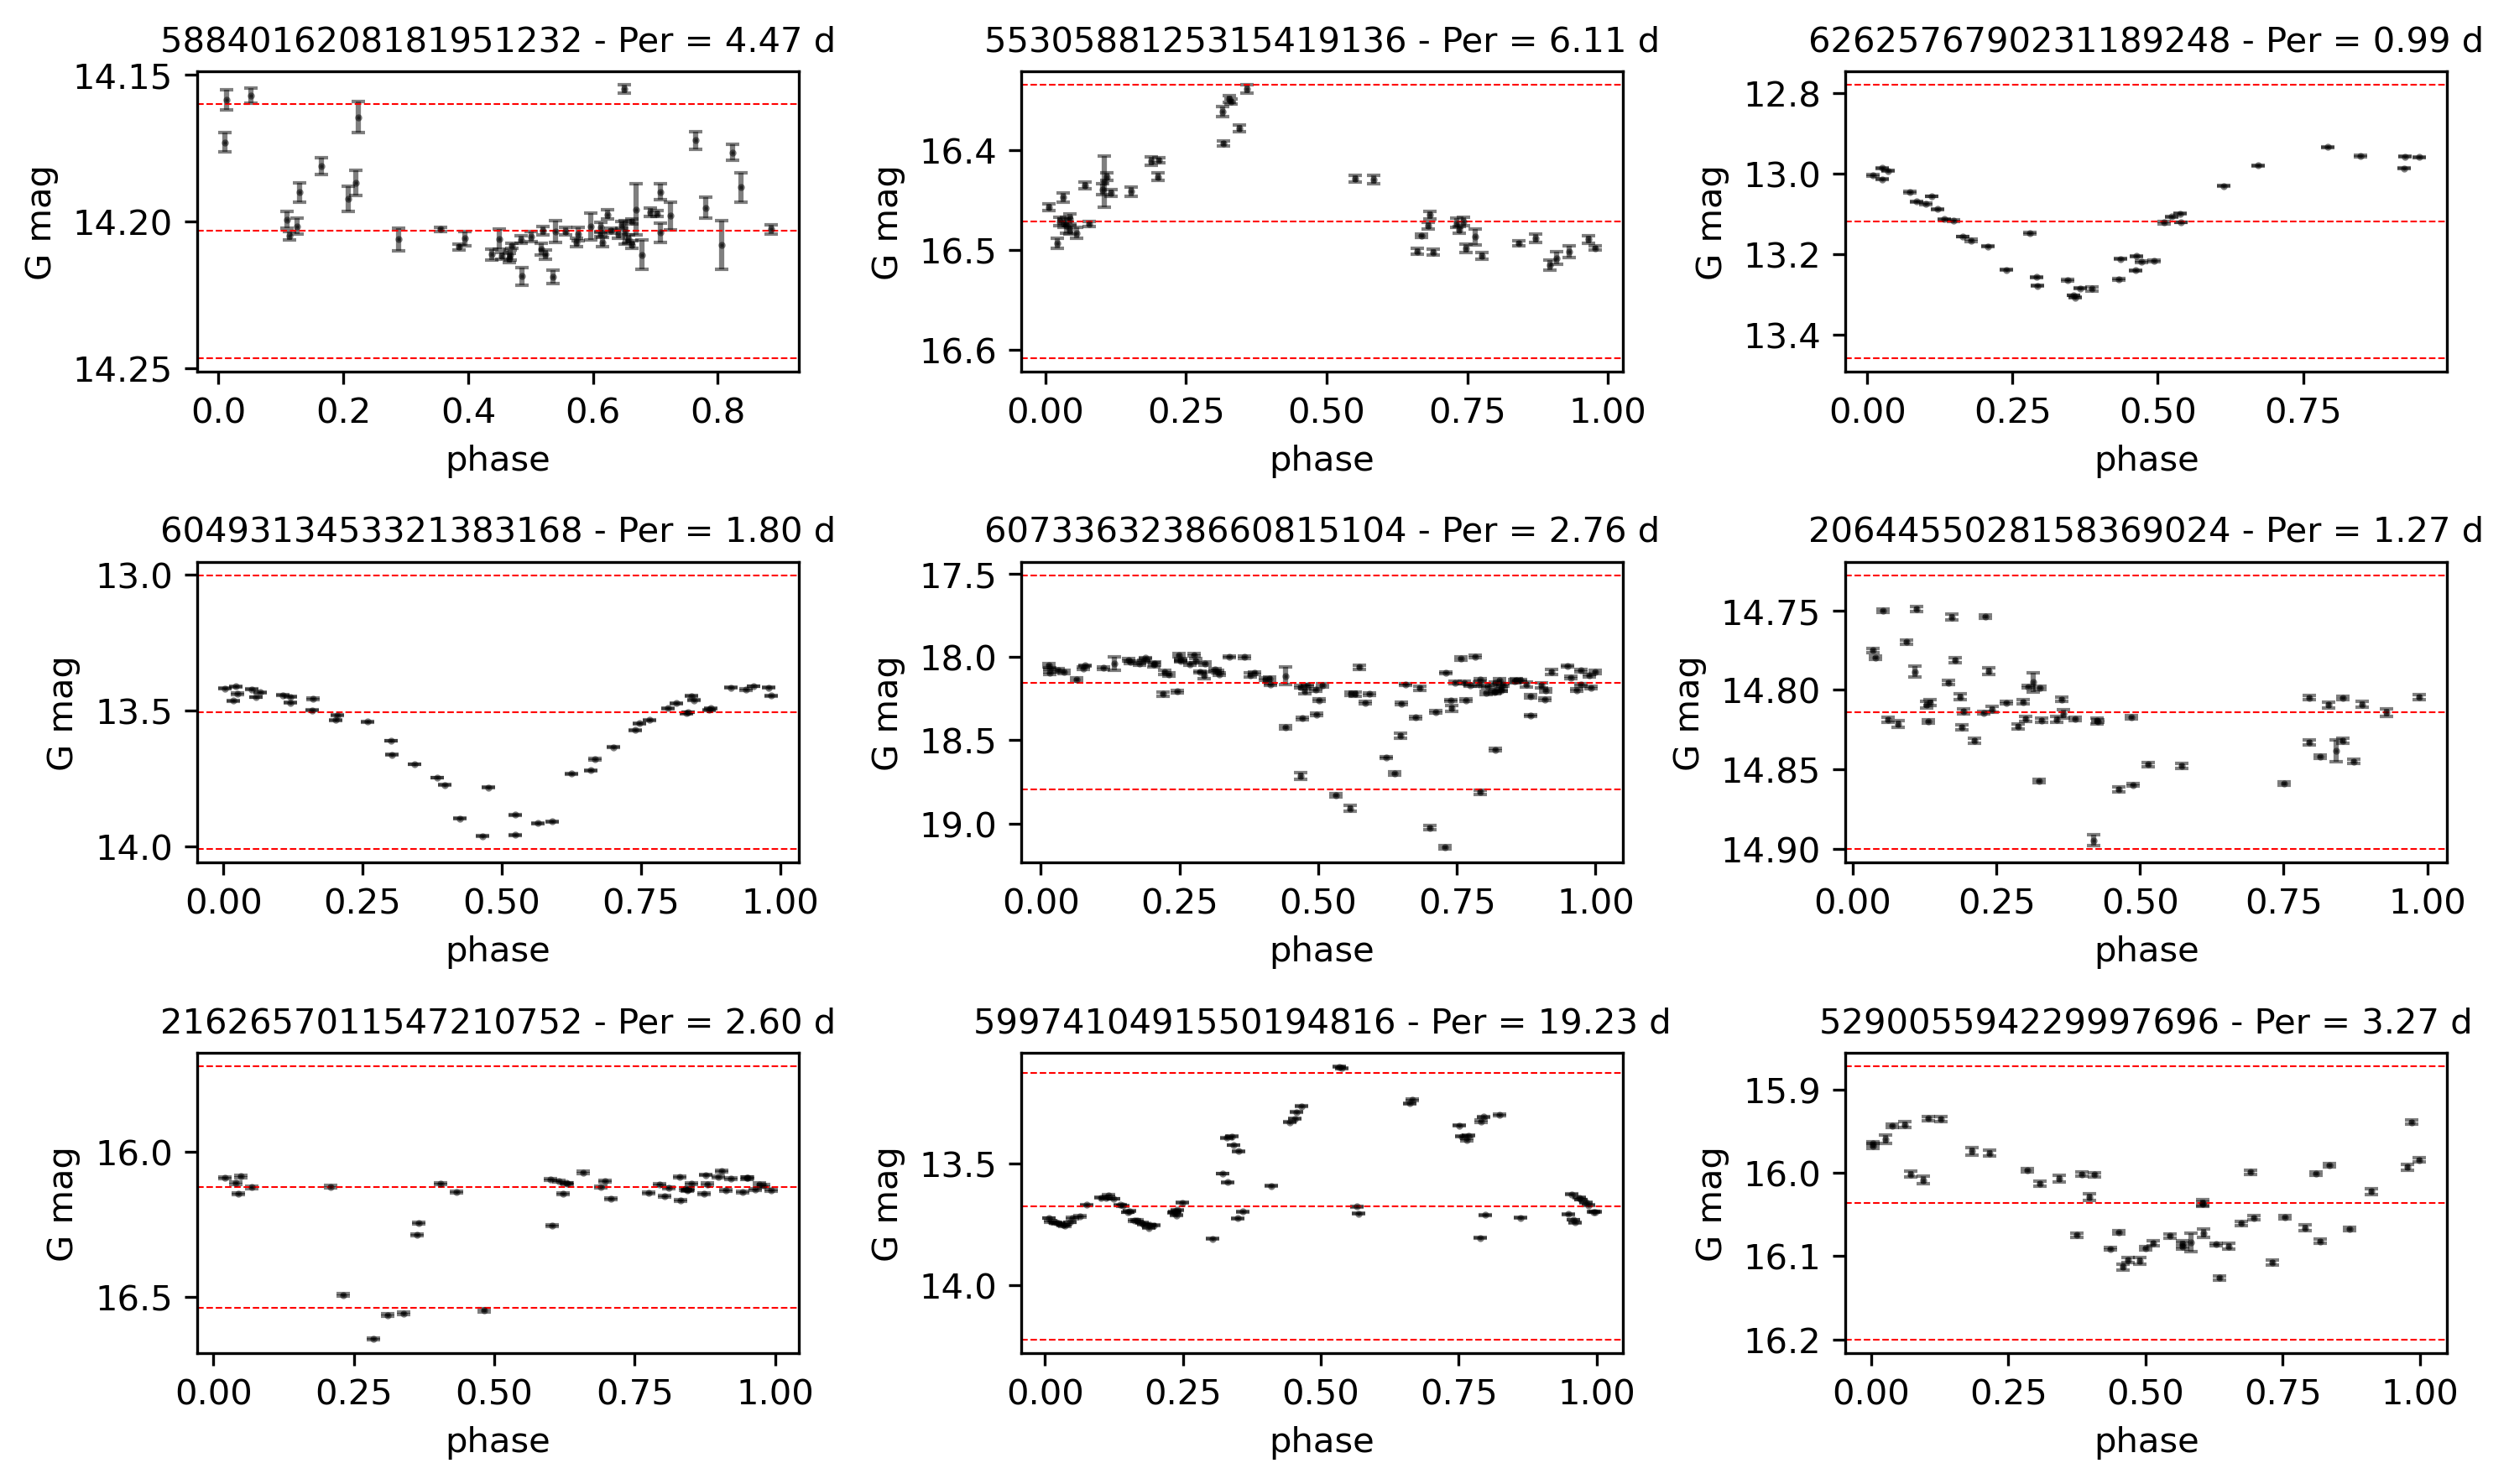

In [18]:
fig, ax = plt.subplots(3, 3, figsize = (10, 6), dpi=300)
ax = ax.flatten()
for i, source_id in enumerate(ref_stars):
    lc = folded_light_curves[i]
    best_frequency, power_highest_peak, per_type = timescales[i]
    ax[i].errorbar(lc.phase, lc.mag_phased, lc.err_phased, fmt='.', capsize=2, color='k', ms=2, alpha=0.5)
    ax[i].set_title('{0} - Per = {1:.2f} d'.format(source_id, 1./best_frequency), fontsize=10)
    ax[i].set_xlabel('phase')
    ax[i].set_ylabel('G mag')
    ax[i].invert_yaxis()
    ax[i].axhline(np.nanmedian(lc.mag), ls='--', color='r', lw=0.5)
    ax[i].axhline(np.nanmedian(lc.mag) + 3*np.nanstd(lc.mag), ls='--', color='r', lw=0.5)
    ax[i].axhline(np.nanmedian(lc.mag) - 3*np.nanstd(lc.mag), ls='--', color='r', lw=0.5)

plt.tight_layout()

In [19]:
print('source_id \t M_index \t Q_index')
for i, source_id in enumerate(ref_stars):
    lc_p = folded_light_curves[i]
    best_frequency, power_highest_peak, per_type = timescales[i]
    var = VariabilityIndex(lc_p, timescale=1./best_frequency)
    print(source_id, var.M_index.value, var.Q_index.value)

source_id 	 M_index 	 Q_index
5884016208181951232 -1.002222178795021 0.6441793538725933
5530588125315419136 -0.8814584286218867 0.11739816652745663
6262576790231189248 0.04013891144183012 0.07391956552794157
6049313453321383168 0.9835608852581021 0.08236057447656851
6073363238660815104 1.0355194798071052 0.6962892970140558
2064455028158369024 -0.10355352277904192 0.5510472299607796
2162657011547210752 1.416273773195789 0.5776910831423242
5997410491550194816 -0.9772467236552602 0.4532167175329411
529005594229997696 -0.20289684401292205 0.2783363661710504


Accordingly, these values can be used as reference for testing

| source_id 	 |M_index| 	 Q_index|
|-----------------|-----------------|-----------------|
|5884016208181951232 |-1.002222178795021 |0.6441793538725933|
|5530588125315419136 |-0.8814584286218867 |0.11739816652745663|
|6262576790231189248 |0.04013891144183012 |0.07391956552794157|
|6049313453321383168 |0.9835608852581021 |0.08236057447656851|
|6073363238660815104 |1.0355194798071052 |0.6962892970140558|
|2064455028158369024 |-0.10355352277904192 |0.5510472299607796|
|2162657011547210752 |1.416273773195789 |0.5776910831423242|
|5997410491550194816 |-0.9772467236552602 |0.4532167175329411|
|529005594229997696 |-0.20289684401292205 |0.2783363661710504|


Finally, we may want to think of some sort of checksum test for validating the waveforms calculated in both implementations as well. 

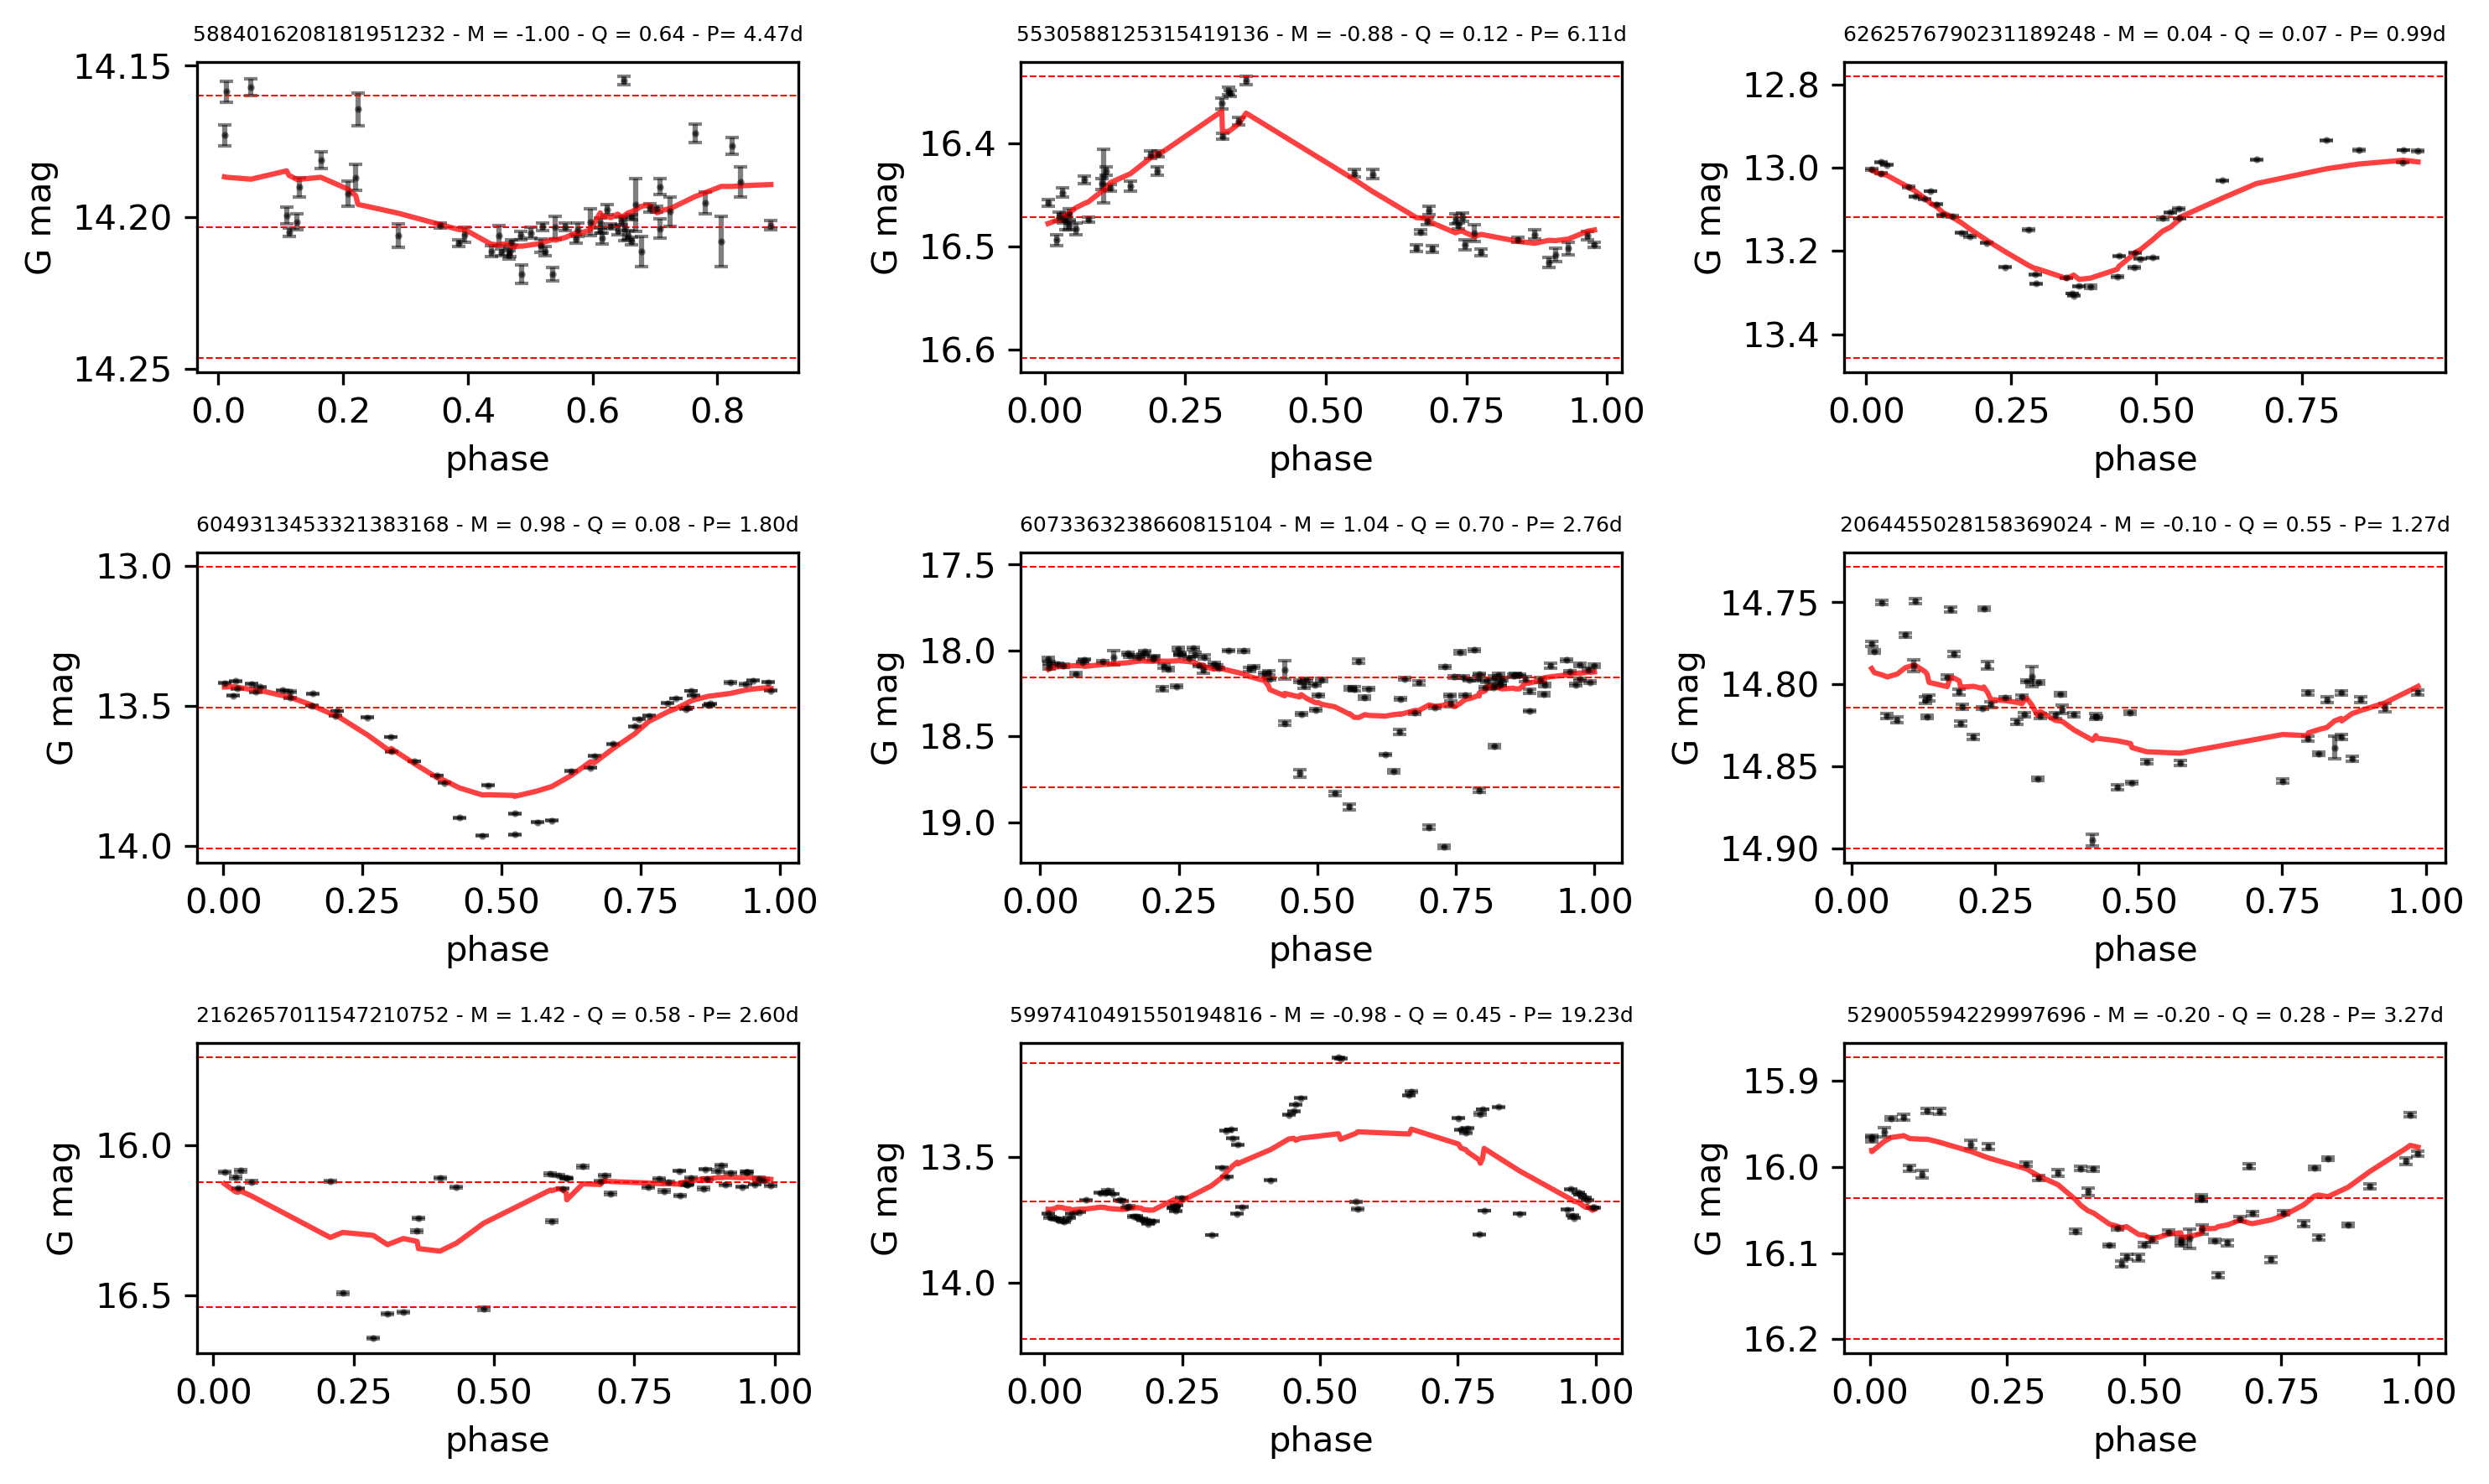

In [20]:
fig, ax = plt.subplots(3, 3, figsize = (10, 6), dpi=300)
ax = ax.flatten()
for i, source_id in enumerate(ref_stars):
    lc = folded_light_curves[i]
    best_frequency, power_highest_peak, per_type = timescales[i]
    var = VariabilityIndex(lc, timescale=1./best_frequency)    
    ax[i].errorbar(lc.phase, lc.mag_phased, lc.err_phased, fmt='.', capsize=2, color='k', ms=2, alpha=0.5)
    ax[i].plot(lc.phase, lc.waveform, 'r-', alpha=0.75)
    ax[i].set_title('{0} - M = {1:.2f} - Q = {2:.2f} - P= {3:.2f}d'.format(source_id, var.M_index.value, var.Q_index.value, 1./best_frequency), fontsize=6)
    ax[i].set_xlabel('phase')
    ax[i].set_ylabel('G mag')
    ax[i].invert_yaxis()
    ax[i].axhline(np.nanmedian(lc.mag), ls='--', color='r', lw=0.5)
    ax[i].axhline(np.nanmedian(lc.mag) + 3*np.nanstd(lc.mag), ls='--', color='r', lw=0.5)
    ax[i].axhline(np.nanmedian(lc.mag) - 3*np.nanstd(lc.mag), ls='--', color='r', lw=0.5)

plt.tight_layout()
plt.savefig('/Users/juliaroquette/Work/Plots/GaiaDR3_testing_stars_savgol_issues_25.png', dpi=300, bbox_inches='tight')